In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

from s7_datasets import load_data_S7_1
from models import model_summary,S7_Model_3
from utils import train_S7,test_S7,plot_acc_loss_S7

c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
use_cuda = torch.cuda.is_available()  # Check if CUDA (GPU support) is available
device = torch.device("cuda" if use_cuda else "cpu")  # Select GPU if available, otherwise fall back to CPU
device  # Display the selected device

device(type='cpu')

In [3]:
trainloader , testloader = load_data_S7_1()

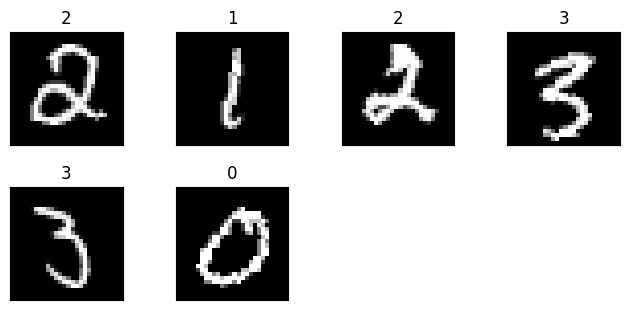

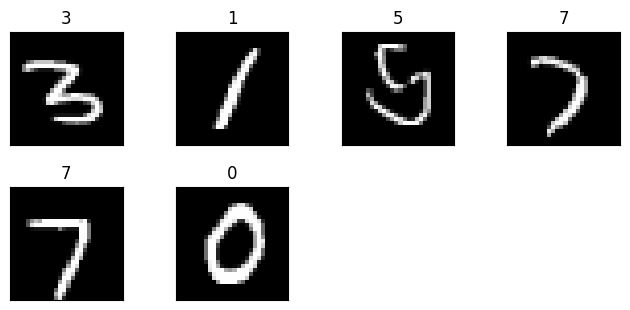

In [8]:
def plot_image(loader,no_images):
    batch_data, batch_label = next(iter(loader))
    _ = plt.figure()

    for i in range(no_images):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])


plot_image(trainloader,6)
plot_image(testloader,6)

In [5]:

model = S7_Model_3()
model_summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             392
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]           2,010
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
            Conv2d-7           [-1, 20, 28, 28]           1,820
       BatchNorm2d-8           [-1, 20, 28, 28]              40
              ReLU-9           [-1, 20, 28, 28]               0
        MaxPool2d-10           [-1, 20, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,896
      BatchNorm2d-12           [-1, 16, 14, 14]              32
             ReLU-13           [-1, 16, 14, 14]               0
          Dropout-14           [-1, 16,

In [6]:
model = S7_Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15




for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_S7(model, device, trainloader, optimizer,criterion)
  test_S7(model, device, testloader, criterion)
  scheduler.step()


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.1843 Batch_id=937 Accuracy=76.69: 100%|██████████| 938/938 [01:58<00:00,  7.95it/s]


Test set: Average loss: 0.0024, Accuracy: 9530/10000 (95.30%)

Epoch 2


Train: Loss=0.1557 Batch_id=937 Accuracy=93.67: 100%|██████████| 938/938 [02:27<00:00,  6.35it/s]


Test set: Average loss: 0.0032, Accuracy: 9361/10000 (93.61%)

Epoch 3


Train: Loss=0.3616 Batch_id=937 Accuracy=95.23: 100%|██████████| 938/938 [03:00<00:00,  5.21it/s]


Test set: Average loss: 0.0014, Accuracy: 9725/10000 (97.25%)

Epoch 4


Train: Loss=0.0536 Batch_id=937 Accuracy=95.95: 100%|██████████| 938/938 [03:03<00:00,  5.12it/s]


Test set: Average loss: 0.0018, Accuracy: 9604/10000 (96.04%)

Epoch 5


Train: Loss=0.1528 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [03:02<00:00,  5.13it/s]


Test set: Average loss: 0.0015, Accuracy: 9689/10000 (96.89%)

Epoch 6


Train: Loss=0.0246 Batch_id=937 Accuracy=96.70: 100%|██████████| 938/938 [03:05<00:00,  5.07it/s]


Test set: Average loss: 0.0010, Accuracy: 9802/10000 (98.02%)

Epoch 7


Train: Loss=0.0713 Batch_id=937 Accuracy=96.67: 100%|██████████| 938/938 [02:59<00:00,  5.22it/s]


Test set: Average loss: 0.0010, Accuracy: 9807/10000 (98.07%)

Epoch 8


Train: Loss=0.1502 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [02:57<00:00,  5.27it/s]


Test set: Average loss: 0.0015, Accuracy: 9678/10000 (96.78%)

Epoch 9


Train: Loss=0.0142 Batch_id=937 Accuracy=97.13: 100%|██████████| 938/938 [02:56<00:00,  5.31it/s]


Test set: Average loss: 0.0008, Accuracy: 9839/10000 (98.39%)

Epoch 10


Train: Loss=0.1519 Batch_id=937 Accuracy=97.21: 100%|██████████| 938/938 [02:59<00:00,  5.22it/s]


Test set: Average loss: 0.0006, Accuracy: 9869/10000 (98.69%)

Epoch 11


Train: Loss=0.0213 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [03:09<00:00,  4.95it/s]


Test set: Average loss: 0.0006, Accuracy: 9867/10000 (98.67%)

Epoch 12


Train: Loss=0.0872 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [02:46<00:00,  5.63it/s]


Test set: Average loss: 0.0007, Accuracy: 9856/10000 (98.56%)

Epoch 13


Train: Loss=0.0236 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [01:31<00:00, 10.22it/s]


Test set: Average loss: 0.0007, Accuracy: 9846/10000 (98.46%)

Epoch 14


Train: Loss=0.1069 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [01:29<00:00, 10.49it/s]


Test set: Average loss: 0.0007, Accuracy: 9858/10000 (98.58%)

Epoch 15


Train: Loss=0.0167 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s]


Test set: Average loss: 0.0005, Accuracy: 9892/10000 (98.92%)



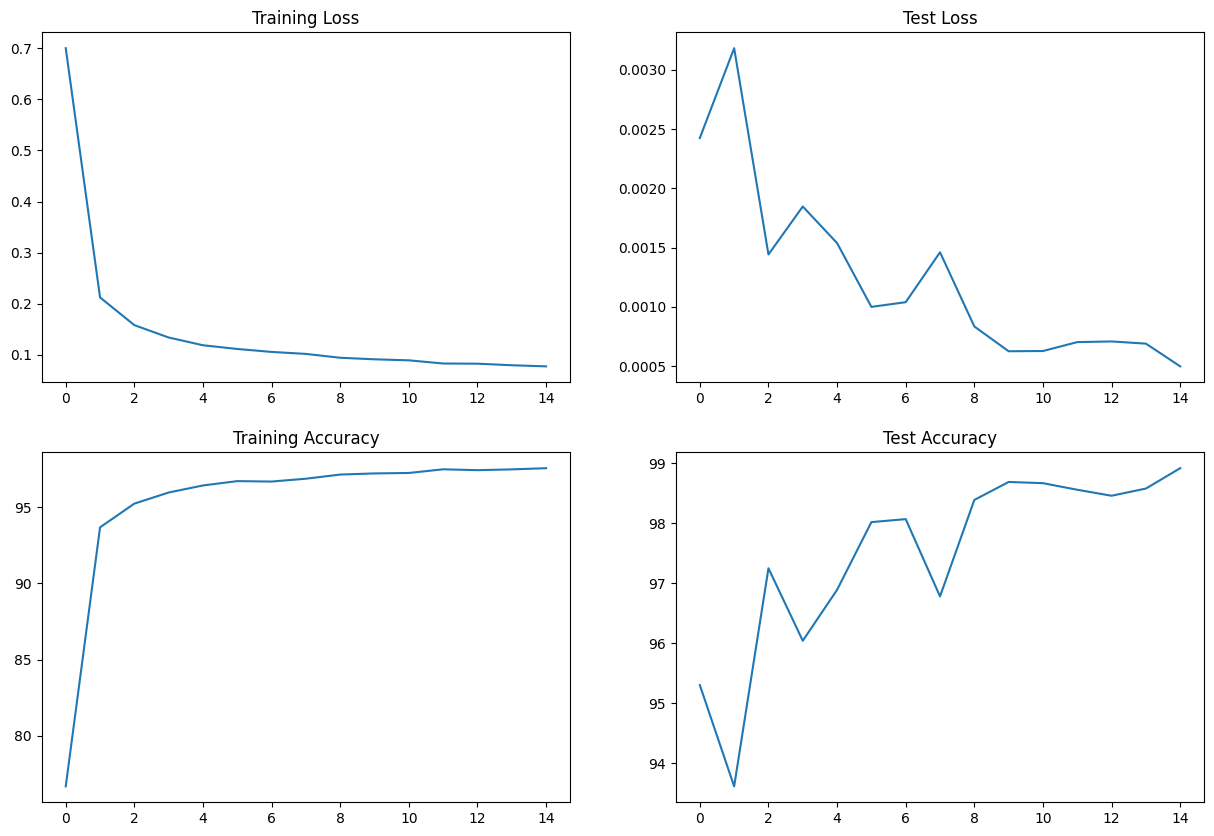

In [7]:
plot_acc_loss_S7()